In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from os import listdir
import pandas as pd
import numpy as np

In [3]:
from dlmi.visualization import *
from dlmi.utils import get_size_of_file, load_pickle
search_type = 'leaf'

# Graph 1 -- Deep1b -- 1M

In [4]:
dyn = '../experiments/2022-12-06--13-17-32-13588502-DEEP1B-9990000-adan8.grid.cesnet.cz'
bulk = '../experiments/2022-12-31--19-48-10-13828512-DEEP1B-bulk-MLP-100000-adan34.grid.cesnet.cz'
# naive_dyn = -- to be done -- 13783000.meta-pbs.metacentrum.cz or more likely 13795635.meta-pbs.metacentrum.cz
naive_dyn = '../experiments/2022-12-31--09-42-11-13827750-DEEP1B-bulk-MLP-100000-adan8.grid.cesnet.cz'

In [5]:
df = pd.read_csv(f'{dyn}/struct/str-27.csv')
n_leaf_nodes_d = df[df['type'] == 'LeafNode'].shape[0]
df = pd.read_csv(f'{bulk}/struct/str-99.csv')
n_leaf_nodes_b = df[df['type'] == 'LeafNode'].shape[0]
df = pd.read_csv(f'{naive_dyn}/struct/str-9.csv')
n_leaf_nodes_nd = df[df['type'] == 'LeafNode'].shape[0]

In [6]:
n_leaf_nodes_d, n_leaf_nodes_b, n_leaf_nodes_nd

(1645, 1600, 160)

In [7]:
def get_search_df(exp, objs=100_000, type_s='leaf'):
    search_df = pd.DataFrame([])
    for f in listdir(f'{exp}/search/{type_s}/csv/'):
        if all(pd.read_csv(f'{exp}/search/{type_s}/csv/{f}')['n-objects-total'].values == objs):
            search_df = pd.concat([search_df, pd.read_csv(f'{exp}/search/{type_s}/csv/{f}')])
    return search_df

In [8]:
def get_recalls(search_df, n_leaf_nodes, search_type='leaf'):
    recalls = []
    mean_recalls = []
    stop_conds = []
    stop_conds_time = []
    seq_search_time = []
    n_queries = 0

    for n, g in search_df.groupby(['sc']):
        n_queries = g['recall'].values.shape[0]
        if search_type == search_type:
            r = (n/n_leaf_nodes)*100
            stop_conds.append(
                f'{round(r, 2) if r < 1 else int(r)}%'
            )
            stop_conds_time.append(round(g['time'].mean(), 3))
            seq_search_time.append(round(g['time-seq-search'].mean(), 3))
        recalls.append(g['recall'].values)
        mean_recalls.append(np.mean(g['recall'].values))
    return recalls, mean_recalls, stop_conds, stop_conds_time, seq_search_time

In [25]:
search_df_d = get_search_df(dyn)
recalls_d, mean_recalls_d, stop_conds, stop_conds_time_d, seq_search_time_d = get_recalls(search_df_d, n_leaf_nodes_d)
search_df_nd = get_search_df(naive_dyn)
recalls_nd, mean_recalls_nd, stop_conds_nd, stop_conds_time_nd, seq_search_time_nd = get_recalls(search_df_nd, n_leaf_nodes_nd)
search_df_b = get_search_df(bulk)
recalls_b, mean_recalls_b, stop_conds_b, stop_conds_time_b, seq_search_time_b = get_recalls(search_df_b, n_leaf_nodes_b)

In [26]:
len(recalls_nd), len(stop_conds_time_nd)

(6, 6)

In [27]:
import matplotlib
font = {'size': 18}

matplotlib.rc('font', **font)

In [28]:
# Remove the '%'
stop_conds = [s[:-1] for s in stop_conds]

In [29]:
# Remove 0 from '0.'
stop_conds = [s[1:] if float(s) < 1 else s for s in stop_conds]

In [30]:
len(recalls_b), stop_conds_b

(9, ['0.06%', '0.25%', '0.5%', '1%', '3%', '5%', '10%', '20%', '30%'])

In [31]:
stop_conds, stop_conds_nd, stop_conds_b

(['.06', '.49', '.97', '2', '4', '9', '20', '29'],
 ['0.62%', '2%', '5%', '10%', '20%', '30%'],
 ['0.06%', '0.25%', '0.5%', '1%', '3%', '5%', '10%', '20%', '30%'])

In [32]:
stop_conds = ['.06', '.25', '.5', '1', '2', '3', '5', '10', '20', '30']
mask_present_d = [1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
mask_present_b = [1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
mask_present_nd = [0, 0, 1, 0, 1, 0, 1, 1, 1, 1]

In [33]:
def plot_line_with_boxplots_graph(
    data_values_a,
    data_values_b,
    data_values_c,
    mean_data_values_a,
    mean_data_values_b,
    mean_data_values_c,
    present_values_a,
    present_values_b,
    present_values_c,
    ticks,
    #ticks_z,
    x_label='',
    title='',
    y_label='',
    legend_loc='lower right',
    ylim=True,
    pad_to_10=False,
    legend='lower right'
):
    """ Creates time-recall and stopcond-recall plots of connected scatterpoints.

    Parameters
    -------
    save : bool
        Should the plot be saved.
    filename : str
        Filename to save as.
    dir_to_save_to : str
        Directory to save to.
    """
    fig, ax = plt.subplots(figsize=(7, 4.3))
    def set_box_color(bp, color):
        for i in ['boxes', 'medians', 'caps', 'whiskers']:
            plt.setp(bp[i], color=color)

    padding = pad_to_10 if pad_to_10 else 0
    colors = ['#D7191C', '#2C7BB6', '#0D8A51']
    
    for en, (color, data_values, positions, present_values) in enumerate(zip(
        colors,
        [data_values_a, data_values_b, data_values_c],
        [np.array(range(len(stop_conds)))*2.0 - 0.5, np.array(range(len(stop_conds)))*2.0, np.array(range(len(stop_conds)))*2.0 + 0.5],
        [present_values_a, present_values_b, present_values_c]
    )):
        data_value_idx = 0
        for pos, present_value in zip(positions, present_values):
            if present_value != 0:
                data_value = data_values[data_value_idx]
                data_value_idx += 1
                bpl = plt.boxplot(data_value, positions=[pos], sym='', widths=0.5)
                set_box_color(bpl, color)

    plt.plot(np.array([i for i in range(len(stop_conds)) if present_values_a[i] != 0])*2.0, mean_data_values_a, marker='o', color=colors[0], label='Static')
    plt.plot(np.array([i for i in range(len(stop_conds)) if present_values_b[i] != 0])*2.0, mean_data_values_b, marker='.', color=colors[1], label='Dynamic')
    plt.plot(np.array([i for i in range(len(stop_conds)) if present_values_c[i] != 0])*2.0, mean_data_values_c, marker='x', color=colors[2], label='Naive dyn.')
    
    plt.legend(prop={'size': 8}, loc=legend_loc)
    plt.xticks(range(0, len(ticks)* 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)

    #plt.xticks(range(0, len(ticks), 1), ticks)
    if ylim:
        plt.ylim(-0.01, 1.05)
    plt.grid(axis='y')
    plt.legend(loc=legend)
    #plt.legend(loc='upper left')
    plt.title(title)
    plt.xlabel(x_label)
    #ax2 = ax.secondary_xaxis('top')
    #ax2.set_xticks(range(0, len(ticks_z)* 2, 2))
    #ax2.set_xticklabels(ticks_z)
    #ax2.set_xlabel('time -- navigation (s)\n time -- sequential search of candidate answer (s)')
    plt.ylabel(y_label)
    return fig

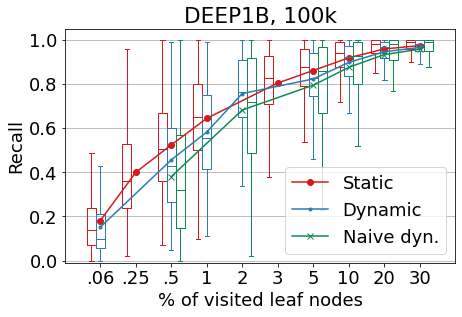

In [34]:
fig = plot_line_with_boxplots_graph(
    recalls_b,
    recalls_d,
    recalls_nd,
    mean_recalls_b,
    mean_recalls_d,
    mean_recalls_nd,
    mask_present_b,
    mask_present_d,
    mask_present_nd,
    stop_conds,
    #joint_stop_conds,
    '% of visited leaf nodes',
    'DEEP1B, 100k',#'Search performance -- GloVe, 1M objects, 1000 queries',
    y_label='Recall',
    pad_to_10=2
)

In [35]:
fig.savefig('../figures/search-deep1b-leaf-100k.pdf', bbox_inches='tight', format='pdf')

In [36]:
search_df_d = get_search_df(dyn, type_s='leaf-absolute')
recalls_d, mean_recalls_d, _, stop_conds_time_d, seq_search_time_d = get_recalls(search_df_d, n_leaf_nodes_d)
search_df_nd = get_search_df(naive_dyn, type_s='leaf-absolute')
recalls_nd, mean_recalls_nd, _, stop_conds_time_nd, seq_search_time_nd = get_recalls(search_df_nd, n_leaf_nodes_nd)
search_df_b = get_search_df(bulk, type_s='leaf-absolute')
recalls_b, mean_recalls_b, _, stop_conds_time_b, seq_search_time_b = get_recalls(search_df_b, n_leaf_nodes_b)

In [37]:
stop_conds = sorted(search_df_b['sc'].unique())

In [38]:
present = [1 for i in range(len(stop_conds))]

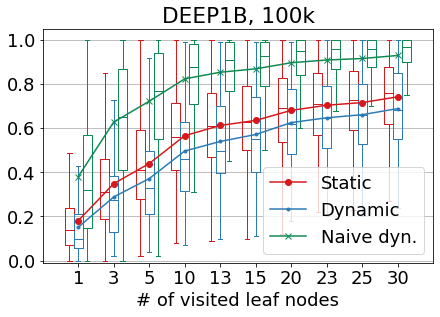

In [39]:
fig = plot_line_with_boxplots_graph(
    recalls_b,
    recalls_d,
    recalls_nd,
    mean_recalls_b,
    mean_recalls_d,
    mean_recalls_nd,
    present,
    present,
    present,
    stop_conds,
    #joint_stop_conds,
    '# of visited leaf nodes',
    'DEEP1B, 100k', #'Search performance -- GloVe, 1M objects, 1000 queries',
    #y_label='Recall'
)

In [40]:
fig.savefig('../figures/search-deep1b-leaf-absolute-100k.pdf', bbox_inches='tight', format='pdf')

In [41]:
stop_conds_time_b, seq_search_time_b, stop_conds_time_nd, seq_search_time_nd

([0.001, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004],
 [0.001, 0.002, 0.002, 0.003, 0.004, 0.004, 0.005, 0.005, 0.006, 0.007],
 [0.001, 0.001, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.003],
 [0.003, 0.007, 0.01, 0.017, 0.021, 0.023, 0.03, 0.033, 0.036, 0.042])

In [42]:
def get_time(search_df, n_leaf_nodes):
    time_mean = []
    time = []
    seq_search_time_mean = []
    seq_search_time = []
    stop_conds = []
    n_queries = 0

    for n, g in search_df.groupby(['sc']):
        n_queries = g['recall'].values.shape[0]
        if search_type == 'leaf':
            r = (n/n_leaf_nodes)*100
            stop_conds.append(
                f'{round(r, 2) if r < 1 else int(r)}%'
            )
        time_mean.append(g['time'].mean())
        time.append(g['time'].values)
        seq_search_time_mean.append(g['time-seq-search'].mean())
        seq_search_time.append(g['time-seq-search'].values)
    return time, time_mean, seq_search_time, seq_search_time_mean, stop_conds

In [43]:
time_d, time_mean_d, seq_time_d, seq_time_mean_d, _ = get_time(search_df_d, n_leaf_nodes_d)
time_b, time_mean_b, seq_time_b, seq_time_mean_b, _ = get_time(search_df_b, n_leaf_nodes_b)
time_nd, time_mean_nd, seq_time_nd, seq_time_mean_nd, _ = get_time(search_df_nd, n_leaf_nodes_nd)

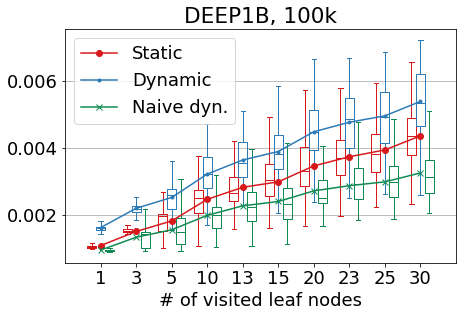

In [44]:
fig = plot_line_with_boxplots_graph(
    time_b,
    time_d,
    time_nd,
    time_mean_b,
    time_mean_d,
    time_mean_nd,
    present,
    present,
    present,
    stop_conds,
    #joint_stop_conds,
    '# of visited leaf nodes',
    'DEEP1B, 100k',
    ylim=False,
    #y_label='Time (s)',
    legend='upper left'
)

In [45]:
fig.savefig('../figures/search-deep1b-leaf-absolute-navigation-costs-100k.pdf', bbox_inches='tight', format='pdf')

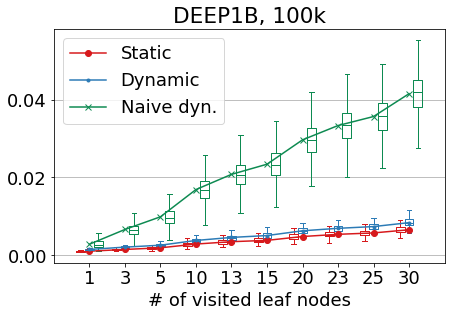

In [46]:
fig = plot_line_with_boxplots_graph(
    seq_time_b,
    seq_time_d,
    seq_time_nd,
    seq_time_mean_b,
    seq_time_mean_d,
    seq_time_mean_nd,
    present,
    present,
    present,
    stop_conds,
    #joint_stop_conds,
    '# of visited leaf nodes',
    'DEEP1B, 100k',
    ylim=False,
    #y_label='Time (s)'
    legend='upper left'
)

In [47]:
fig.savefig('../figures/search-deep1b-leaf-absolute-filtering-costs-100k.pdf', bbox_inches='tight', format='pdf')